#  Application of Machine Learning Techniques to State-Of-Charge Estimation of Calendar-aged Lithium-ion Batteries
Various machine learning algorithms have been used to estimate state-of-charge (SOC) of calendar-aged lithium-ion pouch cells. Calendar life data was generated by applying galvanostatic charge/discharge cycle loads at different storage temperature (35°C and 60°C) and conditions (fully-discharged and fully-charged). The data was obtained at various C-rates for duration of 10 months at one-month intervals. The wininng model, Random Forest (RF), has achieved a R2 score of 99.98% and a mean absolute error (MAE) of 0.14% over test data which is ~10% improvement over the commonly used coulomb-counting method. The model will be employed to estimate the SOC of calendar-aged lithium-ion batteries which is essential for the reliable operation of electric vehicles (EVs).  

## Library Imports

In [16]:
# Numpy and Pandas 
import numpy as np
import pandas as pd

# Vizualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# Machine learning algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Machine learning pipeline 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Check the fitted_model
from sklearn.exceptions import NotFittedError

# Save python obect to disk
import pickle

## Exploratory Analysis

In [17]:
df = pd.read_csv('battery_data.csv')
df.head()

,SOC,Current,Voltage,month,Temp,Charged
0,1.000000,3.059,4.133,0,0,0
1,0.999873,3.043,4.132,0,0,0
2,0.999682,3.046,4.131,0,0,0
3,0.999428,3.041,4.130,0,0,0
4,0.999174,3.044,4.129,0,0,0


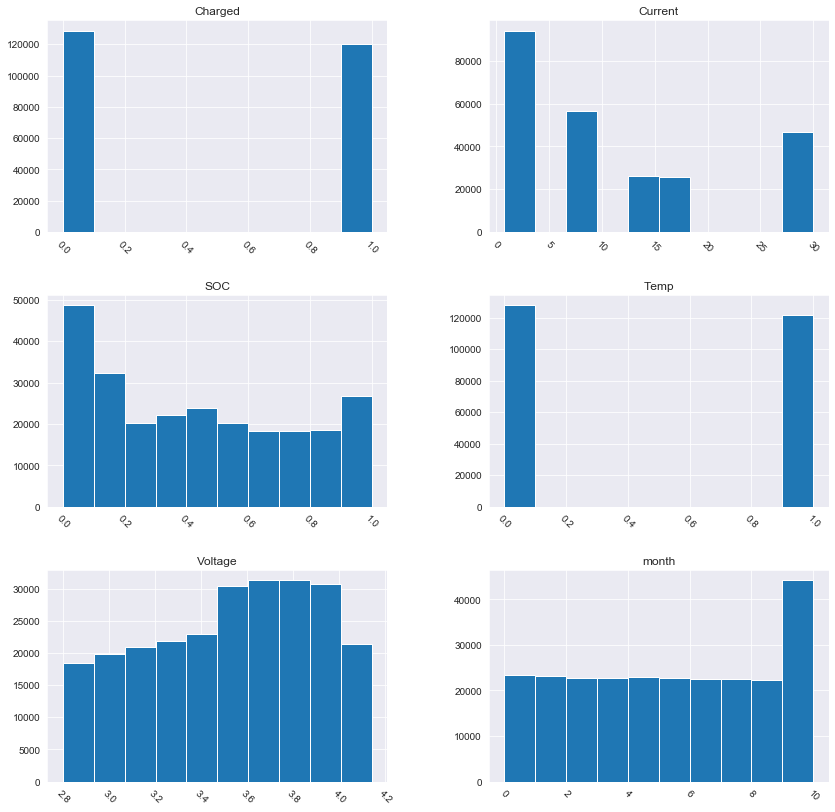

In [18]:
df.hist(figsize=(14,14), xrot=-45)
plt.show()

In [19]:
df.describe()

,SOC,Current,Voltage,month,Temp,Charged
count,249205.000000,249205.000000,249205.000000,249205.000000,249205.000000,249205.000000
mean,0.437959,11.708580,3.519027,4.947617,0.487346,0.483273
std,0.311927,9.886172,0.365043,3.161864,0.499841,0.499721
min,0.000000,0.754406,2.798700,0.000000,0.000000,0.000000
25%,0.135478,3.086750,3.220300,2.000000,0.000000,0.000000
50%,0.405770,7.714810,3.558300,5.000000,0.000000,0.000000
75%,0.707164,15.435000,3.827700,8.000000,1.000000,1.000000
max,1.000000,30.000000,4.140000,10.000000,1.000000,1.000000


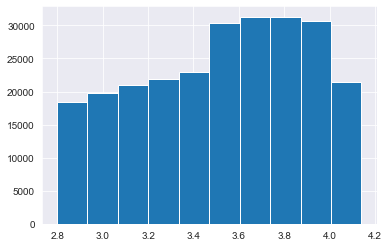

In [20]:
df.Voltage.hist()
plt.show()

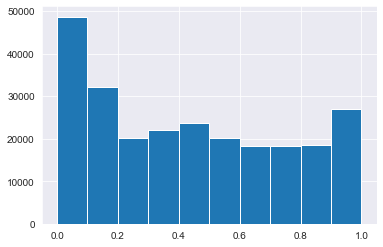

In [21]:
df.SOC.hist()
plt.show()

In [22]:
df.shape

(249205, 6)

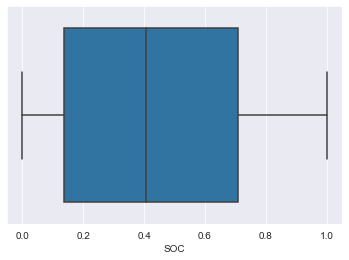

In [23]:
sns.boxplot(df.SOC)
plt.show()

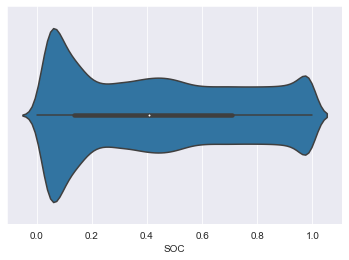

In [24]:
sns.violinplot('SOC', data=df)
plt.show()

In [25]:
correlations = df.corr()
correlations

,SOC,Current,Voltage,month,Temp,Charged
SOC,1.000000,0.021954,0.878562,0.071401,0.100932,0.163667
Current,0.021954,1.000000,-0.126238,0.005347,0.016609,0.019463
Voltage,0.878562,-0.126238,1.000000,-0.016586,-0.019551,-0.018495
month,0.071401,0.005347,-0.016586,1.000000,-0.009545,-0.014474
Temp,0.100932,0.016609,-0.019551,-0.009545,1.000000,-0.022347
Charged,0.163667,0.019463,-0.018495,-0.014474,-0.022347,1.000000


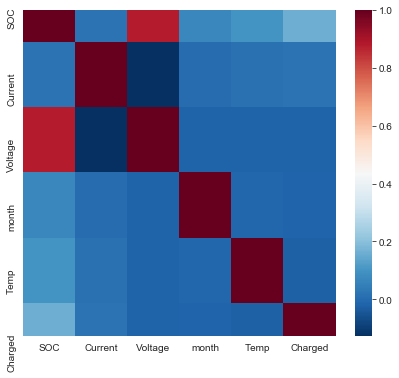

In [26]:
plt.figure(figsize=(7,6))
sns.heatmap(correlations, cmap='RdBu_r')
plt.show()

## Data Cleaning

In [27]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(249205, 6)
(249205, 6)


## Feature Engineering

In [28]:
Vavg_num = 100
V = []
V[:Vavg_num] = df.Voltage[:Vavg_num]
for i in range(Vavg_num,len(df.Voltage)):
    V.append(np.mean(df.Voltage[i-Vavg_num:i]))
df['Vmean'] = V
df.tail()

,SOC,Current,Voltage,month,Temp,Charged,Vmean
249200,0.523254,30.0000,2.8074,10,1,1,2.888221
249201,0.523149,29.9977,2.8054,10,1,1,2.886684
249202,0.523037,30.0000,2.8037,10,1,1,2.885141
249203,0.522942,29.9973,2.8021,10,1,1,2.883595
249204,0.522847,29.9995,2.8003,10,1,1,2.882046


## Algorithm Selection

In [29]:
df['month'] = df['month'].astype(float)
df['Temp'] = df['Temp'].astype(float)
df['Charged'] = df['Charged'].astype(float)
y = df.SOC
X = df.drop('SOC', axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123)) ,
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123)),
    'mlp'   : make_pipeline(StandardScaler(), MLPRegressor(random_state=123))
}

In [31]:
# Check that we have all 5 model families, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>
mlp <class 'sklearn.pipeline.Pipeline'>


In [32]:
MLPRegressor()

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [33]:
lasso_hyperparameters = { 
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]  
}

# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [10, 20],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}

# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [10, 20],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

# MLP hyperparameters
mlp_hyperparameters = {
    'mlpregressor__hidden_layer_sizes': [(100,)],
    'mlpregressor__activation': ['logistic', 'relu']
}

# Create hyperparameters dictionary
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'mlp': mlp_hyperparameters
}

In [34]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso', 'mlp']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.
mlp was found in hyperparameters, and it is a grid.


In [35]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
mlp has been fitted.


In [36]:
# pipeline = make_pipeline(StandardScaler(), MLPRegressor(random_state=123))
# model = GridSearchCV(pipeline , hyperparameters['mlp'], cv=10, n_jobs=-1)

# # Fit model on X_train, y_train
# model.fit(X_train, y_train)

# # Print '{name} has been fitted'
# print('mlp', 'has been fitted.')

In [37]:
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print (name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
mlp has been fitted.


## Model Selection

In [38]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.8523465906736204
ridge 0.8523484245288646
enet 0.8523483134309713
rf 0.9998707807780511
gb 0.9954475428063129
mlp 0.9989078781344964


In [39]:
for name,model in fitted_models.items():
    pred = fitted_models[name].predict(X_test)
    print(name)
    print('R2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))

lasso
R2: 0.8520024521142651
MAE: 0.0975360094266821
ridge
R2: 0.852001997298316
MAE: 0.09753322358629657
enet
R2: 0.8520023794455205
MAE: 0.09753396273592994
rf
R2: 0.999889050911886
MAE: 0.0014171082236115534
gb
R2: 0.9953357870837589
MAE: 0.014492982502335012
mlp
R2: 0.9991135320228985
MAE: 0.006435023245711943


In [40]:
# RF wins!

## Insight & Analysis

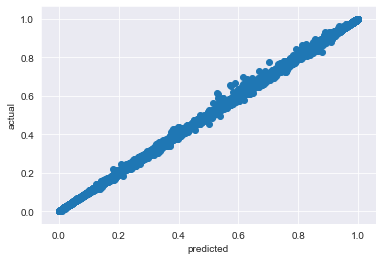

In [42]:
rf_pred = fitted_models['rf'].predict(X_test)
plt.scatter(rf_pred, y_test)
plt.xlabel('predicted')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
plt.ylabel('actual')
plt.show()

In [43]:
fitted_models['rf'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=20, n_jobs=None,
                                       oob_score=False, random_state=123,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [45]:
with open('RF_SOC_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)